# 04. Model Tuning

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load preprocessed data from previous notebook
print("Loading processed data...")
with open('../data/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

Loading processed data...


In [3]:
# Extract data components
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
test_ID = data['test_ID']
numeric_features = data['numeric_features']
categorical_features = data['categorical_features']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2051, 23)
Test data shape: (878, 23)


In [4]:
# Load the best model info from benchmarking
try:
    print("Loading best model from benchmarking step...")
    with open('../data/best_model.pkl', 'rb') as f:
        best_benchmark_model = pickle.load(f)
    
    # Use the model class from benchmark to determine which model to tune
    if hasattr(best_benchmark_model, 'named_steps'):
        model_class = best_benchmark_model.named_steps['model'].__class__.__name__
    else:
        model_class = best_benchmark_model.__class__.__name__
    print(f"Best model from benchmarking: {model_class}")
except:
    print("No best model file found from benchmarking. Using Ridge and Lasso as default.")
    model_class = "Ridge"  # Default to Ridge if no best model found


Loading best model from benchmarking step...
Best model from benchmarking: Ridge


## 1. Setting up Preprocessing Pipeline

In [5]:
print("\n=== SETTING UP PREPROCESSING PIPELINE ===")

# For numerical features: impute and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create preprocessor - robust to having no categorical features
transformers = [('num', numeric_transformer, numeric_features)]
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)


=== SETTING UP PREPROCESSING PIPELINE ===


## 2. Hyperparameter Tuning for Ridge Regression

In [6]:
from sklearn.metrics import make_scorer
print(f"\n=== HYPERPARAMETER TUNING ===")

tuning_results = {}

# Ridge Regression Tuning
# Ridge Regression Tuning
if model_class in ["Ridge", "LinearRegression"]:
    print("\n1. Detailed Ridge Regression Tuning")
    
    ridge_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ])
    
    ridge_param_grid = {'model__alpha': np.logspace(-2, 3, 30)}
    
    ridge_grid = GridSearchCV(
        ridge_pipeline,
        ridge_param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    ridge_grid.fit(X_train, y_train)
    
    print(f"Best Ridge alpha: {ridge_grid.best_params_['model__alpha']:.4f}")
    print(f"Best Ridge CV RMSE: ${-ridge_grid.best_score_:.2f}")
    
    tuning_results['Ridge'] = {
        'best_params': ridge_grid.best_params_,
        'cv_rmse': -ridge_grid.best_score_,
        'model': ridge_grid.best_estimator_
    }


# Lasso Regression Tuning
if model_class in ["Lasso", "LinearRegression"]:
    print("\n2. Detailed Lasso Regression Tuning")
    
    lasso_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Lasso(max_iter=10000))
    ])
    
    lasso_param_grid = {'model__alpha': np.logspace(-4, 0, 100)}
    
    lasso_grid = GridSearchCV(
        lasso_pipeline,
        lasso_param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    lasso_grid.fit(X_train, y_train)
    
    print(f"Best Lasso alpha: {lasso_grid.best_params_['model__alpha']:.6f}")
    print(f"Best Lasso CV RMSE: ${-lasso_grid.best_score_:.2f}")
    
    tuning_results['Lasso'] = {
        'best_params': lasso_grid.best_params_,
        'cv_rmse': -lasso_grid.best_score_,
        'model': lasso_grid.best_estimator_
    }

# ElasticNet Tuning (if applicable)
if model_class == "ElasticNet":
    print("\n3. Detailed ElasticNet Tuning")
    
    elasticnet_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', ElasticNet(max_iter=10000))
    ])
    elasticnet_param_grid = {
        'model__alpha': np.logspace(-4, 0, 10),
        'model__l1_ratio': np.linspace(0.1, 0.9, 9)
    }
    
    elasticnet_grid = GridSearchCV(
        elasticnet_pipeline,
        elasticnet_param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    elasticnet_grid.fit(X_train, y_train)
    
    print(f"Best ElasticNet alpha: {elasticnet_grid.best_params_['model__alpha']:.6f}")
    print(f"Best ElasticNet l1_ratio: {elasticnet_grid.best_params_['model__l1_ratio']:.2f}")
    print(f"Best ElasticNet CV RMSE: ${-elasticnet_grid.best_score_:.2f}")
    
    tuning_results['ElasticNet'] = {
        'best_params': elasticnet_grid.best_params_,
        'cv_rmse': -elasticnet_grid.best_score_,
        'model': elasticnet_grid.best_estimator_
    }


=== HYPERPARAMETER TUNING ===

1. Detailed Ridge Regression Tuning
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Ridge alpha: 0.5298
Best Ridge CV RMSE: $28565.61


## 3. Compared Tuned Models


=== COMPARING TUNED MODELS ===
   Model       CV RMSE                           Parameters
0  Ridge  28565.606816  {'model__alpha': 0.529831690628371}


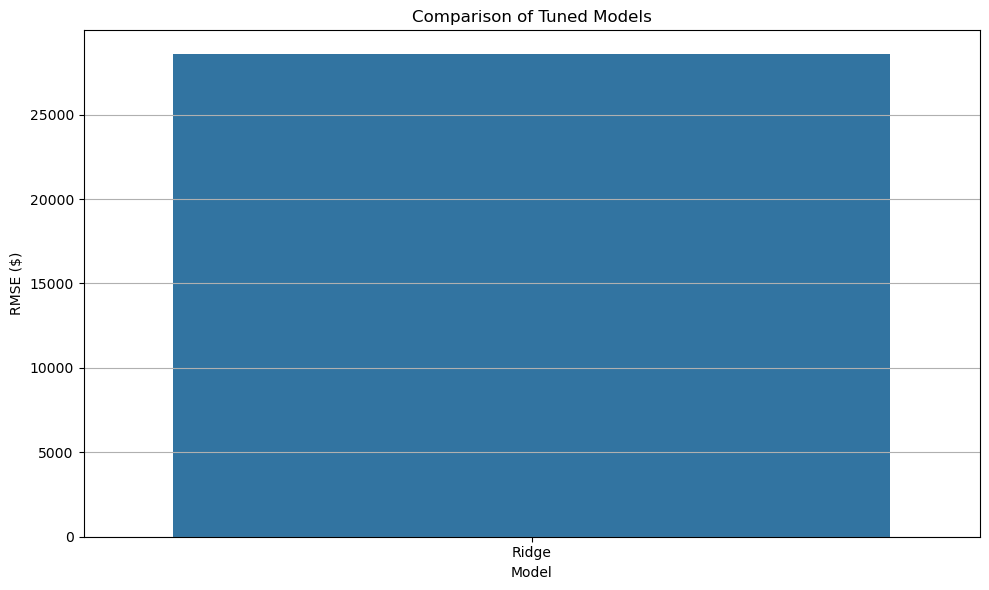

In [7]:
print("\n=== COMPARING TUNED MODELS ===")

# Create comparison DataFrame
tuned_df = pd.DataFrame({
    'Model': list(tuning_results.keys()),
    'CV RMSE': [tuning_results[m]['cv_rmse'] for m in tuning_results],
    'Parameters': [str(tuning_results[m]['best_params']) for m in tuning_results]
})

# Sort by CV RMSE
tuned_df = tuned_df.sort_values('CV RMSE')
print(tuned_df)

# Visualize results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='CV RMSE', data=tuned_df)
plt.title('Comparison of Tuned Models')
plt.ylabel('RMSE ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../images/tuned_models_comparison.png')
plt.show()

## 4. Selecting Final Model and Saving

In [8]:
best_model_name = tuned_df.iloc[0]['Model']
best_model = tuning_results[best_model_name]['model']
best_params = tuning_results[best_model_name]['best_params']
best_rmse = tuned_df.iloc[0]['CV RMSE']

print(f"\n=== BEST MODEL ===")
print(f"Model: {best_model_name}")
print(f"Parameters: {best_params}")
print(f"CV RMSE: ${best_rmse:.2f}")

try:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    prev_scores = cross_val_score(best_benchmark_model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    prev_rmse = -prev_scores.mean()
    
    improvement = prev_rmse - best_rmse
    percent_improvement = (improvement / prev_rmse) * 100
    
    print(f"Benchmark RMSE: ${prev_rmse:.2f}")
    print(f"Tuned RMSE: ${best_rmse:.2f}")
    print(f"Improvement: ${improvement:.2f} ({percent_improvement:.2f}%)")
except:
    print("\nNo benchmark model found for comparison.")

# Save Final Model
with open('../data/final_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Final tuned model saved successfully!")


=== BEST MODEL ===
Model: Ridge
Parameters: {'model__alpha': 0.529831690628371}
CV RMSE: $28565.61
Benchmark RMSE: $31429.61
Tuned RMSE: $28565.61
Improvement: $2864.00 (9.11%)
Final tuned model saved successfully!


## 5. Selecting Final Model and Saving

In [9]:
print("\n=== GENERATING PREDICTIONS ===")

test_predictions = best_model.predict(X_test)

final_submission = pd.DataFrame({'Id': test_ID, 'SalePrice': test_predictions})
final_submission['SalePrice'] = final_submission['SalePrice'].clip(lower=0)
final_submission.to_csv('../data/final_submission.csv', index=False)

print("Final submission file created successfully!")


=== GENERATING PREDICTIONS ===
Final submission file created successfully!
